<a href="https://colab.research.google.com/github/francealip/assignment_1_ISPR_23-24/blob/main/src/LoG_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>ASSIGNMENT 7: implementation of blob detector using laplatian of a gaussian<h2>

<h4><b>Author</b>: Aliprandi Francesco<h4>


<h4><b>1. CODE</b></h4>


In [173]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
#from google.colab import drive
#drive.mount('/content/drive')

<h4><b>1.1 Image processing functions</b></h4>

<b>Laplacian of a gaussian:</b> this function create a laplacian of a gaussian filter creating a meshgrid and applying the second derivative of the gaussian to each point. It's implemented the normalized version that multiply sigma to the second. Filter size is fixed to be 15.

<b>Convolution:</b> implement the convolution with the LoG filter.

<b>Multiple scale execution:</b> implement the convolution with the LoG filters for different scale (sigma). It increase sigma by starting from sigma zero abd by multiplying it to power of the two element.

<b>Find local maxima:</b> find a fixed number local maxima in one convolved image and store them in a quadrupla (x position, y position, value of the pixel, sigma).

<b>Filter max:</b> filter maxima finded in the image to reduce overlapping between filters.

<b>Check in max:</b> support function used by filter max to check if a pixel is already in the max finded so far while filtering.

In [174]:
#Utiliy functions for image processing

def laplacian_of_gaussian(sigma):
    """
    Create the laplacian of a Gaussian filter kernel.

    :parameter sigma: Standard deviation of the Gaussian function.
    :return: LoG filter kernel
    """
    size = 14
    
    #fix odd size for centering the filter
    if(size%2 == 0):
        size = size + 1
        
    x, y = np.meshgrid(np.arange(-size//2 + 1, size//2 + 1), np.arange(-size//2 + 1, size//2 + 1))
    log = ((-1/(np.pi * sigma**2))*(1-((x*x+y*y)/(2*sigma**2)))*np.exp(-(x*x+y*y)/(2*sigma**2)))

    return log

def convolution(img, filter):
    """
    function that performs convolution on the image with LoG filter

    :param img: image to be convoluted
    :param filter: filter to convolve
    :return: convoluted image
    """
    img = np.array(img)

    conv_dim = tuple(x - y + 1 for x, y in zip(img.shape, filter.shape))
    img_conv = np.zeros(conv_dim)
    for i in range(conv_dim[0]):
        for j in range(conv_dim[1]):
            img_conv[i, j] = np.sum(img[i:i+filter.shape[0], j:j+filter.shape[1]]*filter)
    
    return img_conv

def multiple_scale_execution(img, sigma_zero, scales):
    """
    function that performs LoG filter convolution and thresholding on the image for multiple scales

    :param img: image to be processed
    :param sigma_zero: initial sigma value
    :param scales: list of scales
    :return: list of processed images
    """
    k = 2
    img = np.array(img)
    img_list = []
    for i in range(0, scales):
        sigma = sigma_zero*(k**i)
        log_filter = laplacian_of_gaussian(sigma)
        img_conv = convolution(img, log_filter)
        img_list.append(img_conv)    
    return img_list

def find_local_maxima(convolved_image, sigma, number_of_maxima):
    """
    function that find local maxima in one convolved image

    :param convolved_image: convolved image
    :param sigma: sigma value
    :param number_of_maxima: number of maxima to be found
    :return: local maxima
    """
    max_points = []
    
    size = 14
    
    #fix odd size for centering the filter (same dimension of LoG filter kernel)
    if(size%2 == 0):
        size = size + 1
        
    height, width = convolved_image.shape
    
    for i in range(height - size + 1):
        for j in range(width - size + 1):
            section = np.abs(convolved_image[i:i+size, j:j+size])
            max_val = np.max(section)
            max_pos = np.argmax(section)
            max_x = j + max_pos % size
            max_y = i + max_pos // size
            max_points.append((max_x, max_y, max_val, sigma))
    #return best non duplicated 100 maxima and their values
    return sorted(list(set(max_points)), key=lambda x: x[2], reverse=True)[:number_of_maxima]


import math

def filter_max(coordinates, threshold):
    """
    filter nearby maxima by taking the one with highest filter-response value

    :param coordinates: list of maxima coordinates (x, y, z, sigma)
    :param threshold: threshold value
    :return: filtered maxima quadruplpes
    """
    max = {}

    for x1, y1, z1, sigma1 in coordinates:
        x_max, y_max = check_in_max(x1, y1, max, threshold)
        if x_max == -1:
            max[(x1, y1)] = (z1, sigma1)
        else:
            z_max, _ = max[(x_max, y_max)] 
            if(z1 > z_max):
                max[(x_max, y_max)] = (z1, sigma1)         
    # Create list of maxima quadruplas and return
    return [(x, y, z_sigma[0], z_sigma[1]) for (x, y), z_sigma in max.items()]

def check_in_max(x1, y1, max, threshold):
    """
    support function that checks if a coordinate is already in the list of maxima
    
    :param x1: x coordinate to check
    :param y1: y coordinate to check
    :param max: list of maxima so far
    :param threshold: threshold value
    :return: x, y coordinates of the maxima if found, -1, -1 otherwise
    """
    for (x, y), _ in max.items():
        if math.sqrt((x1 - x)**2 + (y1 - y)**2) <= threshold:
            return x, y
    return -1, -1

    

<h4><b>1.2 Support function for plotting</b></h4>

<b>Tridim plot:</b> plot a filter in 3D.

<b>Draw circles:</b> given an image and a set of coordinates (x,y,value,sigma) draw circles in (x,y) position with sigma radius

In [175]:
#support function for plotting

def tridim_plot(LoG_filter,sigma):
    """
    plot of the LoG filter in 3D space

    :parameter LoG_filter: LoG filter kernel
    """
    size = np.ceil(6*sigma)

    # Create vector of coordinates
    x = np.arange(-size//2 , size//2 + 1)
    y = np.arange(-size//2 , size//2 + 1)
    x, y = np.meshgrid(x, y)
    z = LoG_filter

    # Plot 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Filter Value')
    ax.set_title('3D Plot of Laplacian of Gaussian Filter')

    plt.show()
    
        
def draw_circle(image, coordinates):
    """
    plot blob detectors on the specified image
    
    :parameter image: image to be plotted
    :parameter coordinates: list of coordinatets with respectives radius stored as y,x,3
    """
    _, ax = plt.subplots()
    image = np.array(image)
    
    ax.imshow(image, interpolation='nearest',cmap="gray")
    
    for position in coordinates:
        x,y,_,sigma = position
        c = plt.Circle((x, y), sigma, color='red', linewidth=1, fill=False)
        ax.add_patch(c)
        ax.plot()  
    
    plt.axis('off') 
    plt.show()


<h4>2. TEST</h4>

<h4><b>2.1 Support function for testing</b></h4>

<b>Tridim plot:</b> read images in the directory and return them.

<b>Run experiment:</b> execute the logic of blob detector invoking support functions. It works on the image, run convolution number_of_scales times with different sigma. Threshold is the distance value used in filtering maxima. It filters points that are near less than the threshold.

In [176]:
#utility function for testing

def read_images(dir):
    """
    function that read the images in the directory and return a list of images

    :dir: directory path of the images
    :return: list of images
    """
    img = []
    # Loop through each file in the directory
    for filename in os.listdir(dir):
        if filename.endswith(".png"):
            image_path = os.path.join(dir, filename)
            # Open the image and convert to grey scale
            image = Image.open(image_path).convert("L")
            img.append(image)
    return img

def run_experiment(img, sigma_zero, number_of_scales, number_of_maxima, threshold):
    """
    function that runs the experiment on the image

    :param img: image to be processed
    :param sigma_zero: standard deviation of the filter
    :param number_of_scales: number of scales
    :param number_of_maxima: number of maxima to be found
    :param threshold: threshold value
    """
    img = np.array(img)
    feature_maps = multiple_scale_execution(img, sigma_zero,number_of_scales)
    feature_maxima = []

    for i,convolved_image in enumerate(feature_maps):
        sigma = sigma_zero*2**i
        feature_maxima.append(find_local_maxima(convolved_image, sigma, number_of_maxima))

    #unroll list of lists of maxima
    coordinates = [item for sublist in feature_maxima for item in sublist]
    coordinates = filter_max(coordinates,threshold)
    draw_circle(img, coordinates)
    


<h4><b>2.2 Getting images and run experiments</b></h4>

In [177]:
#get images

current_dir = os. getcwd()
parent_dir = os.path.dirname(current_dir)
img_dir = os.path.join(parent_dir, "images")

#add for colab dependences 
#img_dir  = os.getcwd() + "/drive/MyDrive/ispr/assignment1"

#read the three test images
img1, img2, img3 = read_images(img_dir)


<h4><b>2.2 Test on image 1</b></h4>

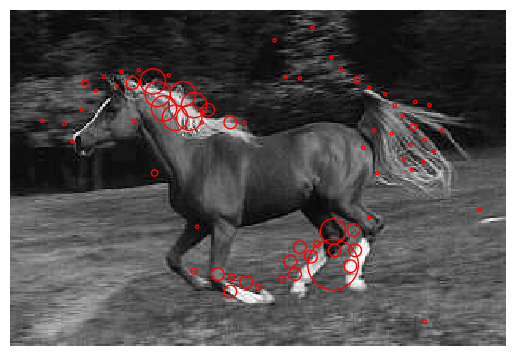

In [179]:
sigma_zero = 1
number_of_scales = 5
number_of_maxima = 500
threshold = 8.5


run_experiment(img1, sigma_zero, number_of_scales, number_of_maxima, threshold)


<h4><b>2.3 Test on image 2</b></h4>


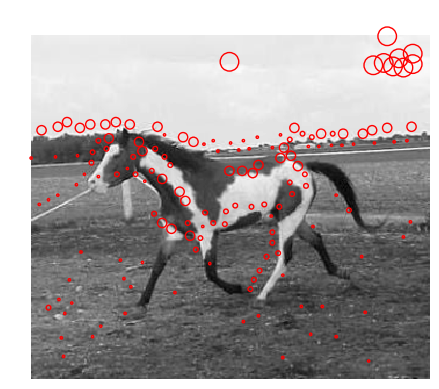

In [180]:
sigma_zero = 1
number_of_scales = 5
number_of_maxima = 500
threshold = 8.5

run_experiment(img2, sigma_zero, number_of_scales, number_of_maxima, threshold)


<h4><b>2.4 Test on image 3</b></h4>


In [ ]:
sigma_zero = 1
number_of_scales = 5
number_of_maxima = 500
threshold = 8.5

run_experiment(img3, sigma_zero, number_of_scales, number_of_maxima, threshold)